In [97]:
import vaex as vx
import pandas as pd
import numpy as np
from geopy.distance import geodesic

In [98]:
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import contextily as ctx 
from shapely.geometry import Point, Polygon
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

In [100]:
#Import machine learning libraries
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [4]:
#Haversine distance calculator
def haversine_dist(lat1, lon1, lat2, lon2):
    p = 0.017453292519943295 # Pi/180
    a = 0.5 - np.cos((lat2 - lat1) * p)/2 + np.cos(lat1 * p) * np.cos(lat2 * p) * (1 - np.cos((lon2 - lon1) * p)) / 2
    return 0.6213712 * 12742 * np.arcsin(np.sqrt(a)) 

In [5]:
def handle_fare_outliers(data):
    #Detect and handle outliers
    fare_25th_percentile = data.percentile_approx('fare_amount', 25)
    fare_75th_percentile = data.percentile_approx('fare_amount', 75)
    IQR = fare_75th_percentile - fare_25th_percentile
    
    # Calculate the lower and upper bounds for outliers
    lower_bound = fare_25th_percentile - 1.5 * IQR
    upper_bound = fare_75th_percentile + 1.5 * IQR
    
    #Print no. of outliers present
    outliers = data[(data['fare_amount'] < lower_bound) | (data['fare_amount'] > upper_bound)]
    print(f"Number of outliers before: {len(outliers)}")
    
    #handling outliers
    data = data[(data['fare_amount'] >= lower_bound) & (data['fare_amount'] <= upper_bound) &
                        (data['fare_amount'] > 0)]
    
    #Print no. of outliers present
    outliers = data[(data['fare_amount'] < lower_bound) | (data['fare_amount'] > upper_bound)]
    print(f"Number of outliers after: {len(outliers)}")
    
    return data


In [6]:
def handle_distance_outliers(data):
    #Calculate IQR
    distance_25th_percentile = data['distance_miles'].quantile(0.25)
    distance_75th_percentile = data['distance_miles'].quantile(0.75)
    IQR = distance_75th_percentile - distance_25th_percentile
    
    # Calculate the lower and upper bounds for outliers
    lower_bound = distance_25th_percentile - 1.5 * IQR
    upper_bound = distance_75th_percentile + 1.5 * IQR
    
    #Print total no. of outlier
    outliers = data[(data['distance_miles'] < lower_bound) | (data['distance_miles'] > upper_bound)]
    print(f"Number of outliers before: {len(outliers)}")
    
    #Handling outliers
    data = data[(data['distance_miles'] >= lower_bound) & (data['distance_miles'] <= upper_bound)]
    
    #Print total no. of outliers
    outliers = data[(data['distance_miles'] < lower_bound) | (data['distance_miles'] > upper_bound)]
    print(f"Number of outliers after: {len(outliers)}")
 
    return data


In [7]:
def handle_location_outliers(data):
    # Define valid NYC boundaries for latitude and longitude
    lat_min, lat_max = 40.4774, 40.9176
    lon_min, lon_max = -74.2591, -73.7004
    
    #Print total no. of outliers for pickup/dropoff locations
    pickup_lat_long_outliers = data[
    (data['pickup_latitude'] < lat_min) | (data['pickup_latitude'] > lat_max) |
    (data['pickup_longitude'] < lon_min) | (data['pickup_longitude'] > lon_max)
].count()

    dropoff_lat_long_outliers = data[
    (data['dropoff_latitude'] < lat_min) | (data['dropoff_latitude'] > lat_max) |
    (data['dropoff_longitude'] < lon_min) | (data['dropoff_longitude'] > lon_max)
].count()

    print(f"Number of detected pickup outliers before: {pickup_lat_long_outliers}")
    print(f"Number of detected dropoff outliers before: {dropoff_lat_long_outliers}")

    #Handle location outliers
    data = data[
    (data['pickup_latitude'] >= lat_min) & (data['pickup_latitude'] <= lat_max) &
    (data['pickup_longitude'] >= lon_min) & (data['pickup_longitude'] <= lon_max) &
    (data['dropoff_latitude'] >= lat_min) & (data['dropoff_latitude'] <= lat_max) &
    (data['dropoff_longitude'] >= lon_min) & (data['dropoff_longitude'] <= lon_max)
]

    #Print total no. of outliers for pickup/dropoff locations
    pickup_lat_long_outliers = data[
    (data['pickup_latitude'] < lat_min) | (data['pickup_latitude'] > lat_max) |
    (data['pickup_longitude'] < lon_min) | (data['pickup_longitude'] > lon_max)
].count()

    # Detect outliers in dropoff coordinates
    dropoff_lat_long_outliers = data[
    (data['dropoff_latitude'] < lat_min) | (data['dropoff_latitude'] > lat_max) |
    (data['dropoff_longitude'] < lon_min) | (data['dropoff_longitude'] > lon_max)
].count()

    print(f"Number of detected pickup outliers after: {pickup_lat_long_outliers}")
    print(f"Number of detected dropoff outliers after: {dropoff_lat_long_outliers}")
    
    return data
    

In [8]:
def handle_passenger_count_outliers(data):
    #Checking how many records are not within acceptable passenger range
    outliers_count = data[(data['passenger_count']==0) |  (data['passenger_count'] > 5)]['passenger_count'].count()
    #Print total no. of outliers
    print(f"Number of detected passenger outliers before: {outliers_count}")

    #Handling passenger_count outliers
    data = data[(data['passenger_count'] > 0) &  (data['passenger_count'] <= 5)]
    
    #Print total no. of outliers
    outliers_count = data[(data['passenger_count']==0) |  (data['passenger_count'] > 5)]['passenger_count'].count()
    print(f"Number of detected passenger outliers after: {outliers_count}")

In [9]:
def plot_fare_dist(data):
    # Create a boxplot to check fare_amount distribution
    plt.figure(figsize=(8, 6))
    plt.boxplot(fare_amounts, vert=True, patch_artist=True, showfliers=True)
    plt.ylabel('Fare Amount ($)')
    plt.title('Boxplot of Fare Amount')

In [10]:
def plot_rides_by_hour(data):
    # Group by hour to count the number of rides in each hour
    hourly_rides = data.groupby('hour').size().reset_index(name='total_rides')


    plt.figure(figsize=(14, 8))
    # Create a bar plot
    sns.barplot(
        data=hourly_rides, 
        x='hour', 
        y='total_rides', 
        palette='Blues',  
        edgecolor='black',
        hue='hour',
        legend=False
    )

    # Add titles and labels
    plt.title('Number of Rides for Each Hour of the Day', fontsize=16)
    plt.xlabel('Hour of the Day', fontsize=14)
    plt.ylabel('Total Rides', fontsize=14)
    plt.xticks(rotation=0, fontsize=12)
    plt.yticks(fontsize=12)

    # Add values on top of the bars
    for index, value in enumerate(hourly_rides['total_rides']):
        plt.text(index, value + 0.1, str(value), ha='center', fontsize=12, color='black')


    plt.tight_layout()
    plt.show()

In [11]:
def fare_amt_by_hour(data):
   # Group by hour and calculate the mean fare amount
    hourly_fares = data.groupby('hour')['fare_amount'].mean().reset_index()

    plt.figure(figsize=(14, 8))

    # Create a line plot
    sns.lineplot(
        data=data, 
        x='hour', 
        y='fare_amount', 
        errorbar='sd', 
        marker='o', 
        linewidth=2
    )

    # Add plot titles and labels
    plt.title('Average Fare Amount by Hour', fontsize=16)
    plt.xlabel('Hour of the Day', fontsize=14)
    plt.ylabel('Average Fare Amount ($)', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()

In [12]:
def plot_rides_by_week(data):
    
    # Create bins for weeks of the month
    bins = [0, 7, 14, 21, 32]  # Define bin edges
    labels = ['1-7', '8-14', '15-21', '22-31'] 

    # Assign each day to a week bin with range labels
    data['week_bin'] = pd.cut(data['day_of_month'], bins=bins, labels=labels, right=False)

    # Group by week bin to count the total number of rides
    df_grouped = data.groupby('week_bin', observed=True).size().reset_index(name='total_rides')

    # Set up the plot
    plt.figure(figsize=(12, 6))

    # Create the bar plot
    sns.barplot(
        data=df_grouped, 
        x='week_bin', 
        y='total_rides',
        hue='week_bin',
        palette='Blues_r'
    )

    # Add plot title and labels
    plt.title('Number of Rides by Week', fontsize=16)
    plt.xlabel('Week Range', fontsize=14)
    plt.ylabel('Total Rides', fontsize=14)

    # Highlight the busiest week
    busiest_week = df_grouped.loc[df_grouped['total_rides'].idxmax()]
    plt.axvline(x=df_grouped[df_grouped['week_bin'] == busiest_week['week_bin']].index[0], 
                color='red', linestyle='--', linewidth=2)
    plt.text(df_grouped[df_grouped['week_bin'] == busiest_week['week_bin']].index[0], 
             busiest_week['total_rides'] + 0.5, 
             f'Busiest Week: {busiest_week["week_bin"]}', color='red', fontsize=12, ha='center')


    # Show the plot
    plt.tight_layout()
    plt.show()

In [13]:
def dist_by_fair_amt(data):
    plt.figure(figsize=(14, 10))
    sns.set(style="whitegrid", palette="muted")

    #scatter plot
    scatter = plt.scatter(
        data['distance_miles'], 
        data['fare_amount'], 
        c=data['fare_amount'], 
        cmap='viridis', 
        s=100, 
        alpha=0.7, 
        edgecolors='w'
    )
    plt.title("Distance vs. Fare Amount")
    plt.xlabel("Distance (Miles)")
    plt.ylabel("Fare Amount ($)")

In [14]:
def plot_rides_by_month(data):
    # Group by month to count rides
    df_grouped = data.groupby(['Month_Name'], observed=False).size().reset_index(name='total_rides')

    # Sort the month in calendar order
    month_order = [
        'January', 'February', 'March', 'April', 'May', 'June', 
        'July', 'August', 'September', 'October', 'November', 'December'
    ]

    # Convert the month column to Categorical
    df_grouped['Month_Name'] = pd.Categorical(df_grouped['Month_Name'], categories=month_order, ordered=True)

    # Sort the data by the defined month order
    df_grouped = df_grouped.sort_values('Month_Name')


    # Set up the plot
    plt.figure(figsize=(14, 8))

    # Create the bar plot
    barplot = sns.barplot(
        data=df_grouped, 
        x='Month_Name', 
        y='total_rides', 
        hue='Month_Name',
        palette='tab10'
    )

    # Add plot title and labels
    plt.title('Total Number of Rides for Each Month', fontsize=16)
    plt.xlabel('Month', fontsize=14)
    plt.ylabel('Total Rides', fontsize=14)

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45)

    # Manually create a legend for the months
    legend_labels = month_order
    colors = sns.color_palette('tab10', n_colors=len(month_order))

    # Create legend manually with matching colors
    legend_patches = [plt.Line2D([0], [0], marker='o', color='w', label=legend_labels[i], 
                                 markerfacecolor=colors[i], markersize=10) for i in range(len(legend_labels))]
    plt.legend(handles=legend_patches, title='Month', bbox_to_anchor=(1.05, 1), loc='upper left')

    # Show the plot
    plt.tight_layout()
    plt.show()    

In [15]:
def plot_rides_by_day(data):
    # Group by month to count rides
    df_grouped = data.groupby(['Day_Name'], observed=False).size().reset_index(name='total_rides')

    # Sort the month in calendar order
    day_order = [
        'Sunday','Monday', 'Tuesday', 'Wednesday', 'Thursday',
        'Friday', 'Saturday'
    ]

    # Convert the month column to Categorical to ensure correct order
    df_grouped['Day_Name'] = pd.Categorical(df_grouped['Day_Name'], categories=day_order, ordered=True)

    # Sort the data by the defined month order
    df_grouped = df_grouped.sort_values('Day_Name')


    # Set up the plot
    plt.figure(figsize=(14, 8))

    # Create the bar plot
    barplot = sns.barplot(
        data=df_grouped, 
        x='Day_Name', 
        y='total_rides', 
        hue='Day_Name',
        palette='tab10'
    )

    # Add plot title and labels
    plt.title('Total Number of Rides Each Day', fontsize=16)
    plt.xlabel('Day', fontsize=14)
    plt.ylabel('Total Rides', fontsize=14)

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45)

    # Manually create a legend for the months
    legend_labels = day_order
    colors = sns.color_palette('tab10', n_colors=len(day_order))

    # Create legend manually with matching colors
    legend_patches = [plt.Line2D([0], [0], marker='o', color='w', label=legend_labels[i], 
                                 markerfacecolor=colors[i], markersize=10) for i in range(len(legend_labels))]
    plt.legend(handles=legend_patches, title='Day', bbox_to_anchor=(1.05, 1), loc='upper left')

    # Show the plot
    plt.tight_layout()
    plt.show()    

In [16]:
def plot_high_fares(data):
    # Create Point geometries from latitude and longitude
    geometry = [Point(xy) for xy in zip(data['pickup_longitude'], data['pickup_latitude'])]

    # Create a GeoDataFrame
    gdf = gpd.GeoDataFrame(data, geometry=geometry)

    # Set the CRS (Coordinate Reference System) to WGS84 (latitude/longitude)
    gdf.set_crs(epsg=4326, inplace=True)

    # Convert to a projected CRS for better visualization (e.g., Web Mercator)
    gdf = gdf.to_crs(epsg=3857)

    # Plotting the GeoDataFrame with fare amounts as color
    fig, ax = plt.subplots(figsize=(12, 10))

    # Plot points with fare amount using a scatter plot
    gdf.plot(ax=ax, column='fare_amount', cmap='OrRd', markersize=100, legend=True, alpha=0.7)

    # Add a basemap (contextily) to give geographic context
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

    # Set titles and labels
    plt.title('High-Fare Areas in NYC', fontsize=16)
    plt.xlabel('Longitude', fontsize=12)
    plt.ylabel('Latitude', fontsize=12)

    # Show plot
    plt.tight_layout()
    plt.show()

In [17]:
def plot_fare_by_week_bin(data):
    # Create bins for weeks of the month (with 21-31 being the final label)
    bins = [0, 7, 14, 21, 32]  # Define bin edges
    labels = ['1-7', '8-14', '15-21', '21-31']  # Explicitly define labels

    # Assign each day to a week bin with range labels
    data['week_bin'] = pd.cut(data['day_of_month'], bins=bins, labels=labels, right=False)

    # Set up the plot
    plt.figure(figsize=(14, 7))

    # Create the boxplot
    sns.boxplot(
        data=data, 
        x='week_bin', 
        y='fare_amount',
        palette='coolwarm',
        linewidth=2.5, 
        showmeans=True, 
        meanprops={"marker": "o", "markerfacecolor": "white", "markeredgecolor": "black", "markersize": 8}
    )

    # Add a title and labels
    plt.title('Fare Amount Distribution by Week of the Month', fontsize=18, fontweight='bold')
    plt.xlabel('Week Range', fontsize=14)
    plt.ylabel('Fare Amount ($)', fontsize=14)

    # Add grid lines for easier interpretation
    plt.grid(True, linestyle='--', alpha=0.6)


    plt.xticks(fontsize=12, fontweight='bold')
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.show()

In [18]:
def plot_airports(data):

    # Create Point geometries from latitude and longitude
    geometry = [Point(xy) for xy in zip(data['pickup_longitude'], data['pickup_latitude'])]

    # Create a GeoDataFrame
    gdf = gpd.GeoDataFrame(data, geometry=geometry)

    # Set the CRS (Coordinate Reference System) to WGS84 (latitude/longitude)
    gdf.set_crs(epsg=4326, inplace=True)

    # Define airport locations (JFK, LGA, EWR)
    airports = {
        'JFK': Point(-73.7781, 40.6413),
        'LGA': Point(-73.8740, 40.7769),
        'EWR': Point(-74.1745, 40.6895)
    }

    # Create a GeoDataFrame for airports
    airport_gdf = gpd.GeoDataFrame(
        {'airport': ['JFK', 'LGA', 'EWR'], 'geometry': [airports['JFK'], airports['LGA'], airports['EWR']]},
        crs='EPSG:4326'
    )

    # Buffer airports to create proximity areas - five miles
    airport_gdf = airport_gdf.to_crs(epsg=3857)  
    airport_gdf['buffer'] = airport_gdf.buffer(8046.72)

    # Convert ride data to the same CRS for accurate spatial analysis
    gdf = gdf.to_crs(epsg=3857)

    # Find trips within airport buffer areas using spatial join
    near_airports = gpd.sjoin(gdf, airport_gdf.set_geometry('buffer'), how='inner', predicate='intersects')

    # Plotting the results
    fig, ax = plt.subplots(figsize=(12, 10))

    # Plot the airport buffer zones
    airport_gdf.set_geometry('buffer').plot(ax=ax, color='blue', alpha=0.3, edgecolor='black', linewidth=1, label='Airport Proximity')

    # Plot the trips near airports, colored by fare amount
    near_airports.plot(ax=ax, column='fare_amount', cmap='OrRd', markersize=100, legend=True, alpha=0.7)

    # Add a basemap for context
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

    # Add labels and titles
    plt.title('High-Fare Areas Near NYC Airports', fontsize=16)
    plt.xlabel('Longitude', fontsize=12)
    plt.ylabel('Latitude', fontsize=12)

    # Annotate airport names
    for idx, row in airport_gdf.iterrows():
        ax.annotate(row['airport'], xy=(row.geometry.x, row.geometry.y), xytext=(5, 5),
                    textcoords='offset points', fontsize=12, fontweight='bold', color='darkblue',
                    bbox=dict(facecolor='white', alpha=0.6, edgecolor='none', pad=1))

    # Custom Legend
    custom_legend = [
        Patch(facecolor='blue', edgecolor='black', label='Airport Proximity'),
        Line2D([0], [0], marker='o', color='w', label='High Fare Area', markerfacecolor='red', markersize=10)
    ]
    plt.legend(handles=custom_legend, loc='upper left')

    plt.tight_layout()
    plt.show()


In [19]:
file_path='train.csv.zip'

In [21]:
#Extract data
import zipfile
import os

# Specify the path to the zip file
zip_file_path = 'train.csv.zip'  

# Specify the extraction directory
extract_to = './extracted_data'  

# Ensure the extraction directory exists
os.makedirs(extract_to, exist_ok=True)

# Open the zip file in read mode
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print(f"Files extracted to {extract_to}")

Files extracted to ./extracted_data


In [29]:
#Load data into vaex dataframe
import time

start_time = time.time()
full_data = vx.open('extracted_data/train.csv')
end_time = time.time()

# Print the time taken
print(f"Time taken: {end_time - start_time} seconds")

Time taken: 18.65872812271118 seconds


In [30]:
full_data['key']=full_data.key.astype('datetime64')

In [31]:
full_data.drop(columns=['pickup_datetime'], inplace=True)

#,key,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.000000100,4.5,-73.844311,40.721319,-73.84161,40.712278,1
1,2010-01-05 16:52:16.000000200,16.9,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.000000490,5.7,-73.982738,40.76127,-73.991242,40.750562,2
3,2012-04-21 04:30:42.000000100,7.7,-73.98713,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,-73.968095,40.768008,-73.956655,40.783762,1
...,...,...,...,...,...,...,...
"55,423,851",2014-03-15 03:28:00.000000700,14.0,-74.005272,40.740027,-73.96328,40.762555,1
"55,423,852",2009-03-24 20:46:20.000000200,4.2,-73.957784,40.76553,-73.95164,40.773959,1
"55,423,853",2011-04-02 22:04:24.000000400,14.1,-73.970505,40.752325,-73.960537,40.797342,1
"55,423,854",2011-10-26 05:57:51.000000200,28.900000000000002,-73.980901,40.764629,-73.870605,40.773963,1


In [32]:
#Extract year from the datetime column
full_data['Year'] = full_data['key'].dt.year

In [33]:
#Extract month from datetime column
full_data['Month'] = full_data['key'].dt.month

In [34]:
# Count distinct year values
distinct_years = full_data['Year'].unique()

In [35]:
print(distinct_years)

[2009, 2012, 2015, 2013, 2014, 2011, 2010]


In [36]:
full_data = full_data[full_data['Year'].isin(['2014','2015'])]

# Count distinct year values
distinct_years = full_data['Year'].unique()
print("no. of years are: ", distinct_years)

no. of years are:  [2015, 2014]


In [37]:
#Train-Test split
train_data = full_data[~((full_data['Year']==2015) & (full_data['Month'] > 3))]
test_data = full_data[(full_data['Year']==2015) & (full_data['Month'] > 3)]

In [38]:
train_data.rename('key', 'pickup_datetime')
test_data.rename('key', 'pickup_datetime')

'pickup_datetime'

In [39]:
train_data.head()

#,pickup_datetime,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,Year,Month
0,2014-02-19 07:22:00.000000740,12.5,-73.9864,40.7605,-73.989,40.7371,1,2014,2
1,2014-12-06 20:36:22.000000800,4,-73.9798,40.7519,-73.9794,40.7555,1,2014,12
2,2014-02-19 16:03:00.000000160,5.5,-73.9761,40.7524,-73.9811,40.7593,1,2014,2
3,2015-01-11 03:15:38.000000100,58,-73.9833,40.7387,-73.9332,40.8472,1,2015,1
4,2015-03-12 08:08:38.000000100,4.5,-73.9902,40.7564,-73.9856,40.7628,1,2015,3
5,2014-07-16 10:57:00.000000690,5,-73.9961,40.7419,-73.9922,40.7394,6,2014,7
6,2014-05-01 09:12:00.000000198,7,-73.9662,40.7675,-73.9809,40.7742,6,2014,5
7,2014-01-17 09:03:00.000000187,8.5,-73.9915,40.7506,-73.9857,40.7415,4,2014,1
8,2014-04-29 18:28:00.000000500,16.5,-73.9703,40.7508,-73.9984,40.7249,6,2014,4
9,2014-12-08 16:00:01.000000100,16.5,-73.9828,40.7453,-74.0143,40.7029,1,2014,12


In [41]:
train_data.info()

column,type,unit,description,expression
pickup_datetime,virtual column,,,"astype(__key, 'datetime64')"
fare_amount,float64,,,
pickup_longitude,float64,,,
pickup_latitude,float64,,,
dropoff_longitude,float64,,,
dropoff_latitude,float64,,,
passenger_count,int64,,,
Year,virtual column,,,dt_year(pickup_datetime)
Month,virtual column,,,dt_month(pickup_datetime)
variable,type,unit,description,expression


In [42]:
train_data.describe()

,pickup_datetime,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,Year,Month
data_type,datetime64[ns],float64,float64,float64,float64,float64,int64,int32,int32
count,10181144,10181144,10181144,10181144,10181140,10181140,10181144,10181144,10181144
NA,0,0,0,0,4,4,0,0,0
mean,1970-01-01T00:24:09.199625305,12.863036237322177,-72.51519561889471,39.946204668738176,-72.51631175596621,39.947976701579734,1.691605088779807,2014.18941505984,5.580951217269886
std,11352054565007416.0,31.549124,10.290323,5.671512,10.285795,5.674043,1.355476,0.391838,3.558814
min,2013-12-31T23:58:59.494477824,-176.0,-180.0,-180.0,-714.4,-180.0,0,2014,1
max,2015-04-01T00:00:15.672934400,93963.36,169.972765,69.280403,169.972765,458.65,208,2015,12


# Data Cleaning

## Training data cleaning

In [43]:
#Check the no. of null values
train_data = train_data.dropna()

In [44]:
handle_passenger_count_outliers(train_data)

Number of detected passenger outliers before: 375834
Number of detected passenger outliers after: 0


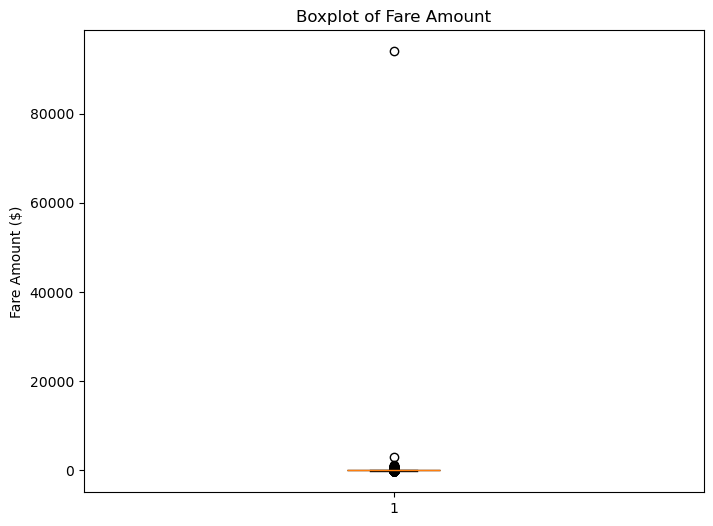

In [45]:
#Boxplot to check fare amount distribution
fare_amounts = train_data['fare_amount'].values
plot_fare_dist(fare_amounts)

In [46]:
train_data = handle_fare_outliers(train_data)

Number of outliers before: 1923
Number of outliers after: 0


In [47]:
train_data = handle_location_outliers(train_data)

Number of detected pickup outliers before: 202165
Number of detected dropoff outliers before: 206083
Number of detected pickup outliers after: 0
Number of detected dropoff outliers after: 0


In [48]:
# Display the cleaned DataFrame without outliers
print(f"Number of rides after removing outliers: {len(train_data)}")
train_data.head(10)

Number of rides after removing outliers: 9952980


#,pickup_datetime,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,Year,Month
0,2014-02-19 07:22:00.000000740,12.5,-73.9864,40.7605,-73.989,40.7371,1,2014,2
1,2014-12-06 20:36:22.000000800,4,-73.9798,40.7519,-73.9794,40.7555,1,2014,12
2,2014-02-19 16:03:00.000000160,5.5,-73.9761,40.7524,-73.9811,40.7593,1,2014,2
3,2015-01-11 03:15:38.000000100,58,-73.9833,40.7387,-73.9332,40.8472,1,2015,1
4,2015-03-12 08:08:38.000000100,4.5,-73.9902,40.7564,-73.9856,40.7628,1,2015,3
5,2014-07-16 10:57:00.000000690,5,-73.9961,40.7419,-73.9922,40.7394,6,2014,7
6,2014-05-01 09:12:00.000000198,7,-73.9662,40.7675,-73.9809,40.7742,6,2014,5
7,2014-01-17 09:03:00.000000187,8.5,-73.9915,40.7506,-73.9857,40.7415,4,2014,1
8,2014-04-29 18:28:00.000000500,16.5,-73.9703,40.7508,-73.9984,40.7249,6,2014,4
9,2014-12-08 16:00:01.000000100,16.5,-73.9828,40.7453,-74.0143,40.7029,1,2014,12


In [49]:
#Convert it to pandas dataframe
train_data = train_data.to_pandas_df()

## Test data cleaning

In [50]:
#Check the no. of null values
test_data = test_data.dropna()

In [51]:
handle_passenger_count_outliers(test_data)

Number of detected passenger outliers before: 69329
Number of detected passenger outliers after: 0


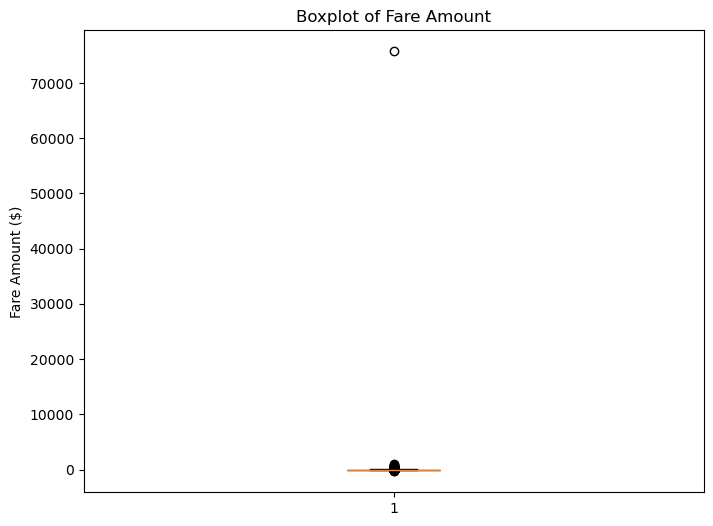

In [52]:
#Boxplot to check fare amount distribution
fare_amounts = test_data['fare_amount'].values
plot_fare_dist(fare_amounts)

In [53]:
test_data = handle_fare_outliers(test_data)

Number of outliers before: 5302
Number of outliers after: 0


In [54]:
test_data = handle_location_outliers(test_data)

Number of detected pickup outliers before: 29582
Number of detected dropoff outliers before: 29082
Number of detected pickup outliers after: 0
Number of detected dropoff outliers after: 0


In [55]:
# Display the cleaned DataFrame without outliers
print(f"Number of rides after removing outliers: {len(test_data)}")
test_data.head(10)

Number of rides after removing outliers: 1888737


#,pickup_datetime,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,Year,Month
0,2015-06-21 21:46:34.000000100,22.54,-74.0105,40.7177,-73.9858,40.6604,1,2015,6
1,2015-04-12 10:19:05.000000100,11.5,-73.9793,40.7234,-74.0046,40.7469,6,2015,4
2,2015-05-12 23:51:42.000000700,5,-73.9548,40.7793,-73.9449,40.7801,1,2015,5
3,2015-04-03 16:21:30.000000500,11,-73.9811,40.7743,-73.959,40.7807,2,2015,4
4,2015-05-17 08:02:59.000000200,14,-73.9792,40.7237,-74.0175,40.7114,1,2015,5
5,2015-05-31 07:33:18.000000200,16.5,-73.997,40.7554,-73.9532,40.8021,3,2015,5
6,2015-04-19 22:21:12.000000500,8,-73.9855,40.7473,-74.0077,40.7408,1,2015,4
7,2015-04-18 09:30:31.000000200,5.5,-73.9809,40.7421,-73.977,40.7517,1,2015,4
8,2015-05-25 15:11:09.000000600,11,-73.9722,40.7656,-73.9796,40.7365,1,2015,5
9,2015-04-30 14:07:57.000000200,16.5,-74.004,40.748,-73.9832,40.7563,1,2015,4


In [56]:
#Convert it to pandas dataframe
test_data = test_data.to_pandas_df()

# Feature Engineering

## training data

In [59]:
#Add datetime features
train_data['day_of_month'] = train_data['pickup_datetime'].dt.day
train_data['hour'] = train_data['pickup_datetime'].dt.hour
train_data['day_of_week'] = train_data['pickup_datetime'].dt.weekday

In [60]:
#Add distance between pickup and drop locations
train_data['distance_miles'] = haversine_dist(train_data['pickup_latitude'], train_data['pickup_longitude'], \
                                      train_data['dropoff_latitude'], train_data['dropoff_longitude'])

In [61]:
train_data = handle_distance_outliers(train_data)

Number of outliers before: 869353
Number of outliers after: 0


In [62]:
train_data.head()

,pickup_datetime,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,Year,Month,day_of_month,hour,day_of_week,distance_miles
0,2014-02-19 07:22:00.000000740,12.5,-73.986430,40.760465,-73.988990,40.737075,1,2014,2,19,7,2,1.621639
1,2014-12-06 20:36:22.000000800,4.0,-73.979815,40.751902,-73.979446,40.755481,1,2014,12,6,20,5,0.248038
2,2014-02-19 16:03:00.000000160,5.5,-73.976075,40.752422,-73.981082,40.759285,1,2014,2,19,16,2,0.541782
4,2015-03-12 08:08:38.000000100,4.5,-73.990173,40.756447,-73.985619,40.762829,1,2015,3,12,8,3,0.501260
5,2014-07-16 10:57:00.000000690,5.0,-73.996148,40.741890,-73.992202,40.739425,6,2014,7,16,10,2,0.267731


In [63]:
# Coordinates for the three major airports in New York
airports_coords = {
    'JFK': (40.6413, -73.7781),
    'LaGuardia': (40.7769, -73.8740),
    'Newark': (40.6895, -74.1745)
}

# Function to determine if the pickup location is closer than 5 miles to any airport
def is_close_to_airport(row, airports=airports_coords):
    lat, lon = row['pickup_latitude'], row['pickup_longitude']
    for coords in airports.values():
        if haversine_dist(lat, lon, coords[0], coords[1]) <= 5:
            return 1
    return 0

In [64]:
# Apply the function to create a new column 'closer_to_airport'
train_data['closer_to_airport'] = train_data.apply(is_close_to_airport, axis=1)

In [65]:
train_data.shape

(9083627, 14)

In [66]:
train_data.head()

,pickup_datetime,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,Year,Month,day_of_month,hour,day_of_week,distance_miles,closer_to_airport
0,2014-02-19 07:22:00.000000740,12.5,-73.986430,40.760465,-73.988990,40.737075,1,2014,2,19,7,2,1.621639,0
1,2014-12-06 20:36:22.000000800,4.0,-73.979815,40.751902,-73.979446,40.755481,1,2014,12,6,20,5,0.248038,0
2,2014-02-19 16:03:00.000000160,5.5,-73.976075,40.752422,-73.981082,40.759285,1,2014,2,19,16,2,0.541782,0
4,2015-03-12 08:08:38.000000100,4.5,-73.990173,40.756447,-73.985619,40.762829,1,2015,3,12,8,3,0.501260,0
5,2014-07-16 10:57:00.000000690,5.0,-73.996148,40.741890,-73.992202,40.739425,6,2014,7,16,10,2,0.267731,0


## test data

In [67]:
#Add datetime features
test_data['day_of_month'] = test_data['pickup_datetime'].dt.day
test_data['hour'] = test_data['pickup_datetime'].dt.hour
test_data['day_of_week'] = test_data['pickup_datetime'].dt.weekday

In [68]:
#Add distance between pickup and drop locations
test_data['distance_miles'] = haversine_dist(test_data['pickup_latitude'], test_data['pickup_longitude'], \
                                      test_data['dropoff_latitude'], test_data['dropoff_longitude'])

In [69]:
test_data = handle_distance_outliers(test_data)

Number of outliers before: 172542
Number of outliers after: 0


In [70]:
# Apply the function to create a new column 'close_to_airport'
test_data['closer_to_airport'] = test_data.apply(is_close_to_airport, axis=1)

In [71]:
test_data.head()

,pickup_datetime,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,Year,Month,day_of_month,hour,day_of_week,distance_miles,closer_to_airport
0,2015-06-21 21:46:34.000000100,22.54,-74.010483,40.717667,-73.985771,40.660366,1,2015,6,21,21,6,4.165394,0
1,2015-04-12 10:19:05.000000100,11.50,-73.979279,40.723438,-74.004608,40.746948,6,2015,4,12,10,6,2.096949,0
2,2015-05-12 23:51:42.000000700,5.00,-73.954796,40.779335,-73.944931,40.780087,1,2015,5,12,23,1,0.518725,1
3,2015-04-03 16:21:30.000000500,11.00,-73.981056,40.774265,-73.959045,40.780674,2,2015,4,3,16,4,1.233822,0
4,2015-05-17 08:02:59.000000200,14.00,-73.979210,40.723682,-74.017464,40.711395,1,2015,5,17,8,6,2.175747,0


In [72]:
test_data.shape

(1716195, 14)

# EDA

In [73]:
#Take a random sample of 5% of the dataset from training and test dataset
train_sample = train_data.sample(frac=0.05, random_state=42) 

In [74]:
train_sample['Month_Name'] = train_sample['pickup_datetime'].dt.month_name()
train_sample['Day_Name'] = train_sample['pickup_datetime'].dt.day_name()

In [75]:
train_sample.head()

,pickup_datetime,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,Year,Month,day_of_month,hour,day_of_week,distance_miles,closer_to_airport,Month_Name,Day_Name
1578466,2014-12-06 03:33:07.000000300,10.0,-73.965995,40.758241,-73.983278,40.726523,1,2014,12,6,3,5,2.370915,1,December,Saturday
6758224,2014-09-26 23:06:17.000000300,6.5,-73.998979,40.745566,-74.000218,40.732639,1,2014,9,26,23,4,0.895522,0,September,Friday
8332383,2014-11-13 11:01:00.000000460,12.0,-74.006192,40.739817,-73.994465,40.721952,1,2014,11,13,11,3,1.378630,0,November,Thursday
3487446,2014-04-23 16:19:25.000000100,8.5,-73.980753,40.778296,-73.997007,40.762888,1,2014,4,23,16,2,1.362618,0,April,Wednesday
1627140,2015-01-19 08:31:08.000000200,11.0,-73.997108,40.762688,-73.988251,40.737129,3,2015,1,19,8,0,1.825769,0,January,Monday


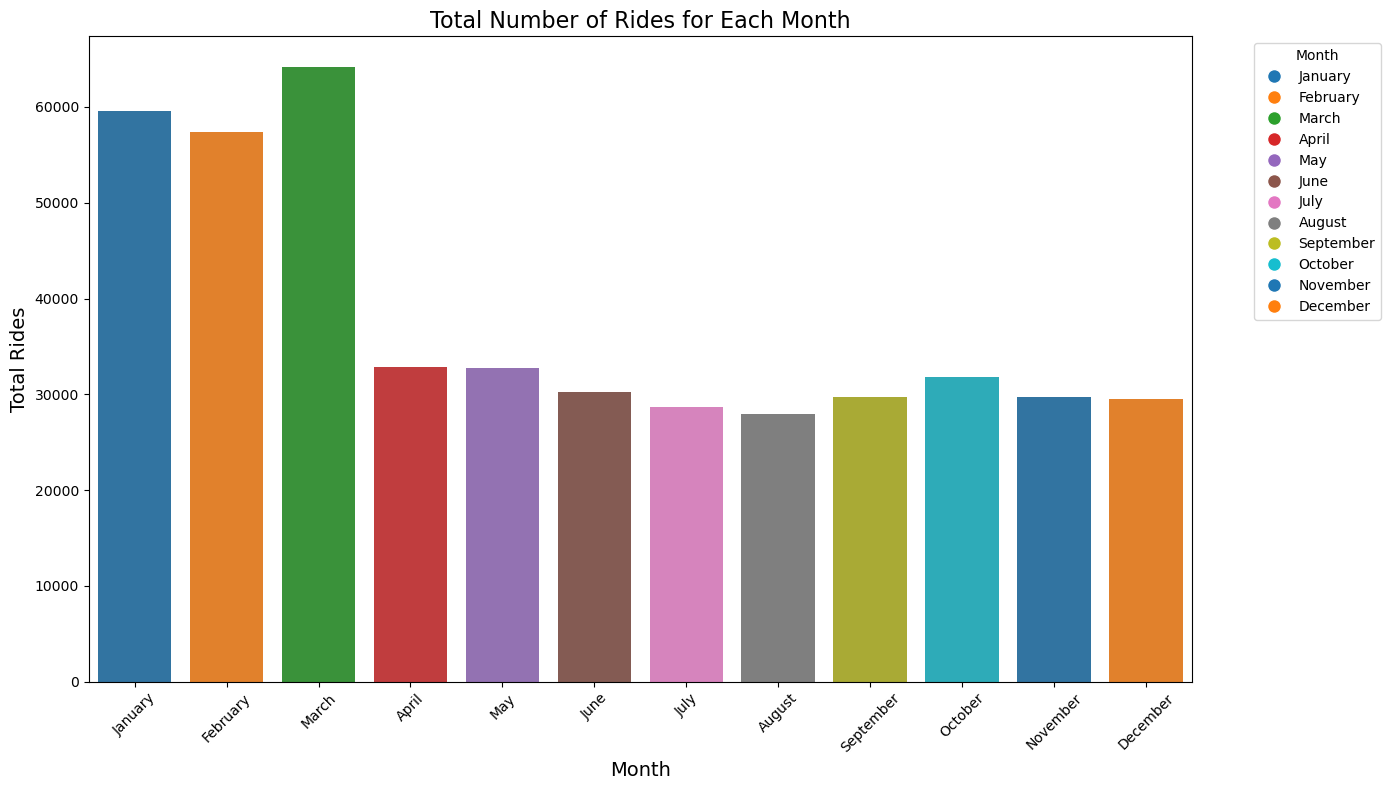

In [76]:
plot_rides_by_month(train_sample)

- **March is the busiest month followed by January and February**

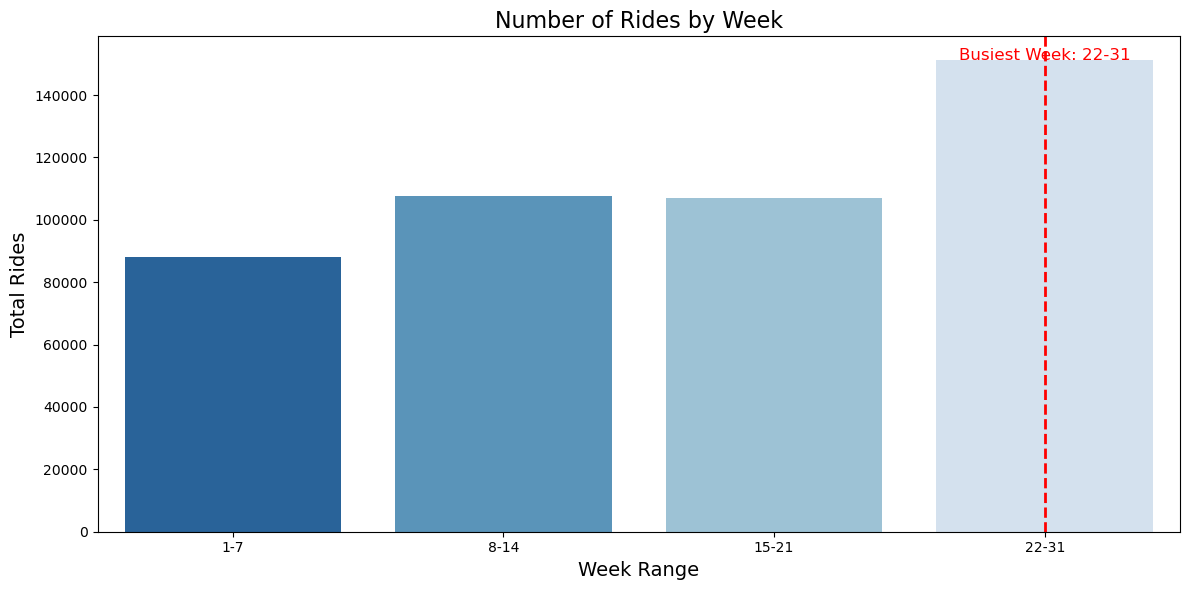

In [77]:
plot_rides_by_week(train_sample)

- **End of the month is usually the busiest time**

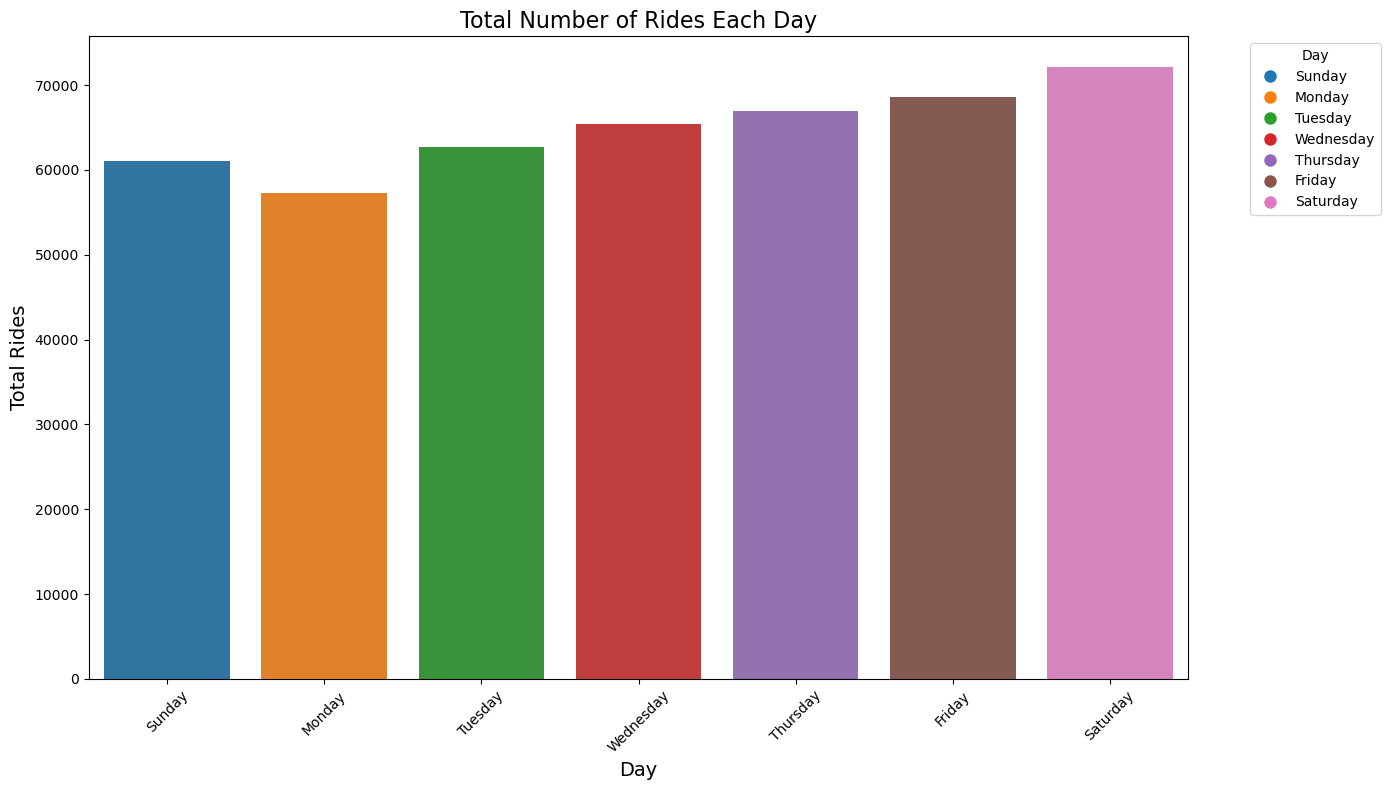

In [78]:
plot_rides_by_day(train_sample)

- **Top three busiest days of the week are Saturday, Friday, and Thursday**

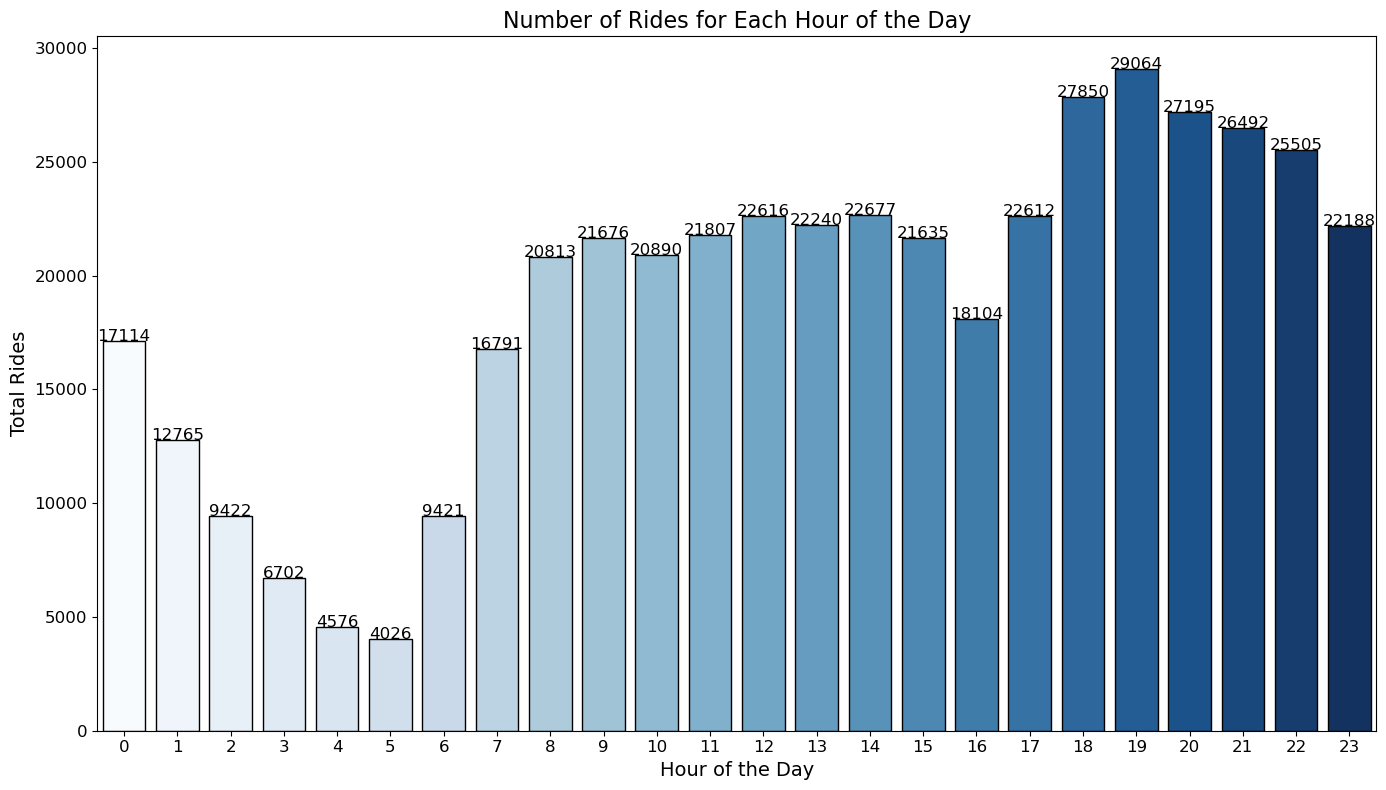

In [79]:
plot_rides_by_hour(train_sample)

- **6PM to 10PM are the busiest hours**

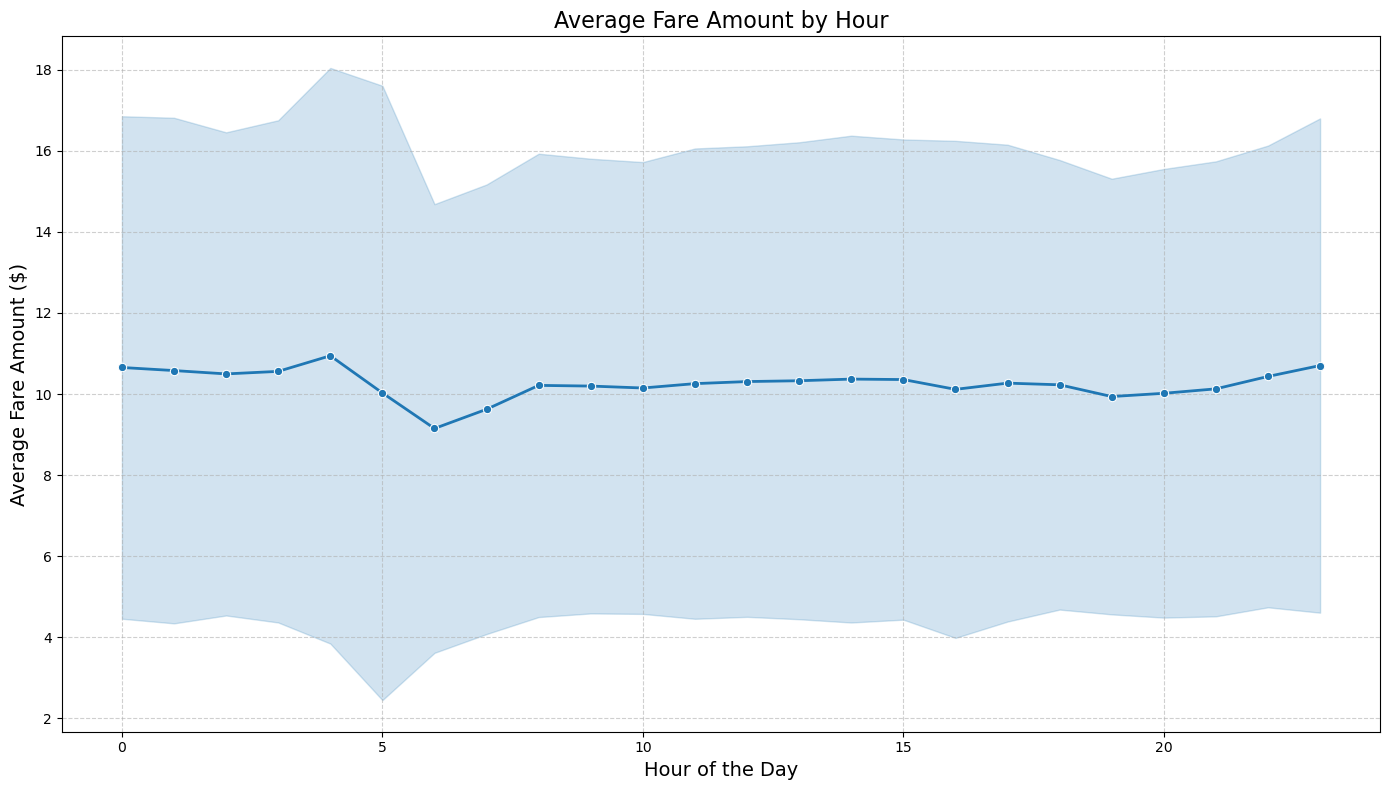

In [80]:
fare_amt_by_hour(train_sample)

- **There is a huge variation in the fare_amount.**

- **Overall avg. fare is between 10-12 dollars. Fares are lower than ten dollars between 5am - 7am.**

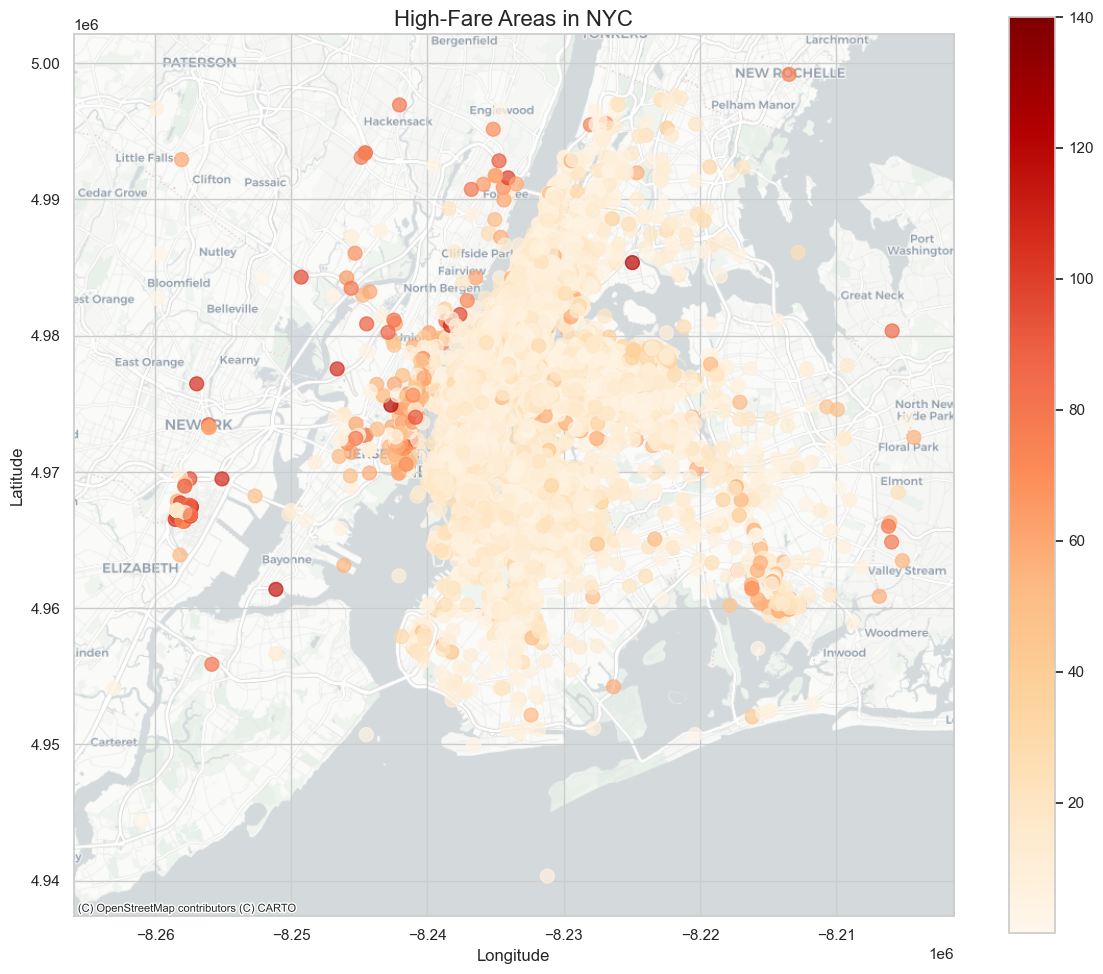

In [82]:
plot_high_fares(train_sample)

**Most of the rides are low fare rides with a few outliers**

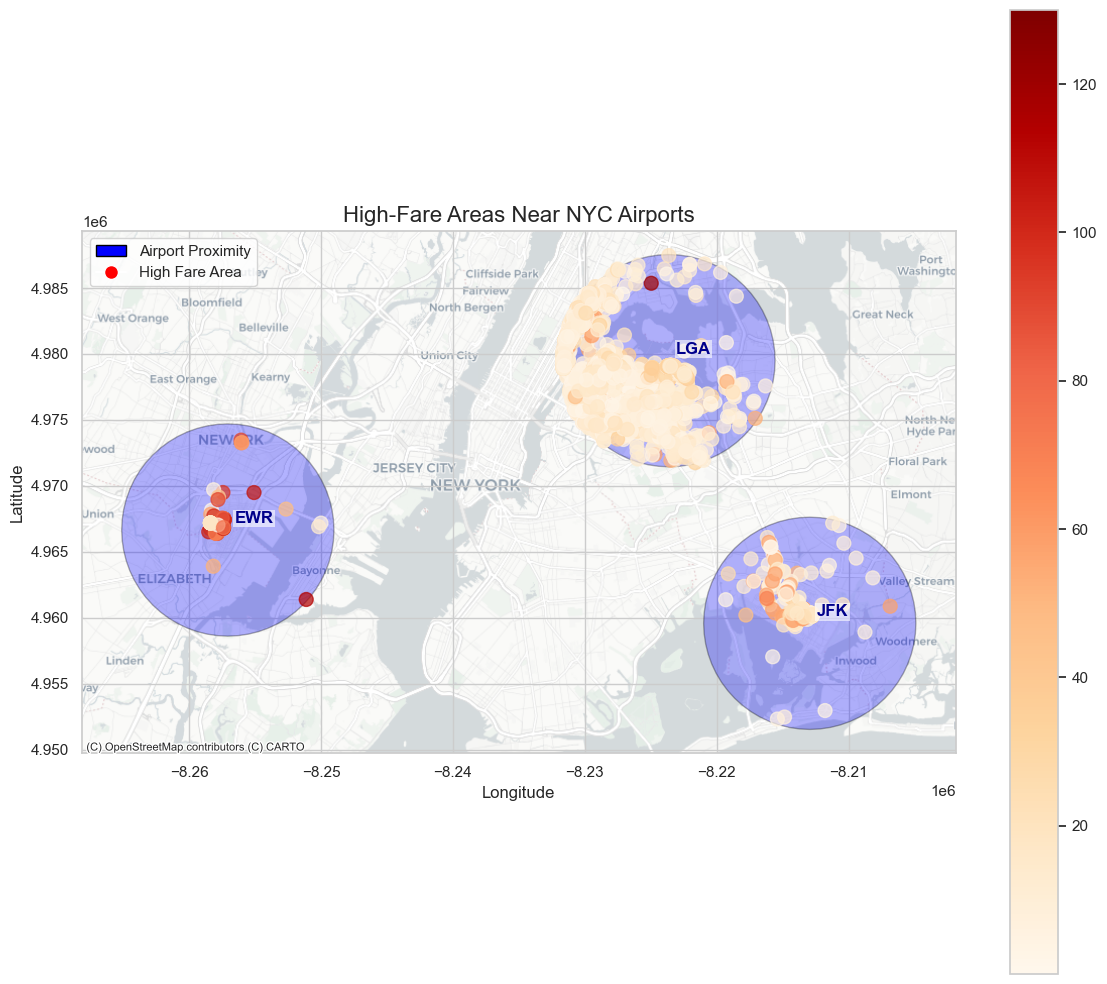

In [83]:
plot_airports(train_sample)

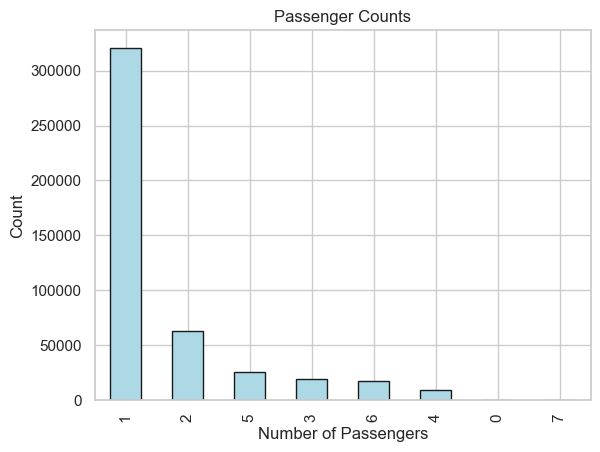

In [84]:
train_sample['passenger_count'].value_counts().plot.bar(color = 'lightblue', edgecolor = 'k')

plt.title('Passenger Counts')
plt.xlabel('Number of Passengers')
plt.ylabel('Count')
plt.show()

- **Most of the passengers prefer to travel alone.**

In [85]:
train_sample.info()

<class 'pandas.core.frame.DataFrame'>
Index: 454181 entries, 1578466 to 3085524
Data columns (total 17 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   pickup_datetime    454181 non-null  datetime64[ns]
 1   fare_amount        454181 non-null  float64       
 2   pickup_longitude   454181 non-null  float64       
 3   pickup_latitude    454181 non-null  float64       
 4   dropoff_longitude  454181 non-null  float64       
 5   dropoff_latitude   454181 non-null  float64       
 6   passenger_count    454181 non-null  int64         
 7   Year               454181 non-null  int32         
 8   Month              454181 non-null  int32         
 9   day_of_month       454181 non-null  int32         
 10  hour               454181 non-null  int32         
 11  day_of_week        454181 non-null  int32         
 12  distance_miles     454181 non-null  float64       
 13  closer_to_airport  454181 non-null  int64 

In [86]:
#Get initial one month dataset to perform hyper-parameter tuning
model_train_data = train_data[(train_data['Year']==2014) & (train_data['Month'] ==1)]

In [87]:
model_train_data.shape

(623261, 14)

In [88]:
train_data.head()

,pickup_datetime,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,Year,Month,day_of_month,hour,day_of_week,distance_miles,closer_to_airport
0,2014-02-19 07:22:00.000000740,12.5,-73.986430,40.760465,-73.988990,40.737075,1,2014,2,19,7,2,1.621639,0
1,2014-12-06 20:36:22.000000800,4.0,-73.979815,40.751902,-73.979446,40.755481,1,2014,12,6,20,5,0.248038,0
2,2014-02-19 16:03:00.000000160,5.5,-73.976075,40.752422,-73.981082,40.759285,1,2014,2,19,16,2,0.541782,0
4,2015-03-12 08:08:38.000000100,4.5,-73.990173,40.756447,-73.985619,40.762829,1,2015,3,12,8,3,0.501260,0
5,2014-07-16 10:57:00.000000690,5.0,-73.996148,40.741890,-73.992202,40.739425,6,2014,7,16,10,2,0.267731,0


In [89]:
train_data.corr()

,pickup_datetime,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,Year,Month,day_of_month,hour,day_of_week,distance_miles,closer_to_airport
pickup_datetime,1.000000,0.002679,0.008077,0.010679,0.009645,0.009879,-0.005795,0.690997,0.297015,0.060219,0.002601,0.000447,-0.012524,0.008649
fare_amount,0.002679,1.000000,0.053003,-0.086743,0.112074,-0.114595,0.010063,-0.018904,0.028165,0.001808,-0.001622,0.003918,0.721351,0.020876
pickup_longitude,0.008077,0.053003,1.000000,0.398798,0.600801,0.215735,-0.008449,0.007176,0.000501,-0.001745,-0.013567,-0.017075,0.027871,0.657474
pickup_latitude,0.010679,-0.086743,0.398798,1.000000,0.179360,0.615979,-0.004973,0.011492,-0.002210,-0.001352,0.032152,-0.049867,-0.075832,0.423721
dropoff_longitude,0.009645,0.112074,0.600801,0.179360,1.000000,0.352846,-0.006180,0.008452,0.000743,-0.001331,-0.035219,-0.005699,0.146373,0.352732
dropoff_latitude,0.009879,-0.114595,0.215735,0.615979,0.352846,1.000000,-0.003503,0.010298,-0.001629,-0.000832,0.025547,-0.040724,-0.073614,0.265150
passenger_count,-0.005795,0.010063,-0.008449,-0.004973,-0.006180,-0.003503,1.000000,-0.005159,-0.000344,0.001080,0.013475,0.025764,0.008624,-0.009270
Year,0.690997,-0.018904,0.007176,0.011492,0.008452,0.010298,-0.005159,1.000000,-0.482555,0.003781,0.001825,0.013581,-0.020122,0.006752
Month,0.297015,0.028165,0.000501,-0.002210,0.000743,-0.001629,-0.000344,-0.482555,1.000000,-0.012002,-0.002314,-0.018110,0.011494,0.001833
day_of_month,0.060219,0.001808,-0.001745,-0.001352,-0.001331,-0.000832,0.001080,0.003781,-0.012002,1.000000,0.007104,0.010538,0.000407,-0.002937


In [90]:
# Define feature columns and target variable
features = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 
            'passenger_count', 'Year', 'Month', 'day_of_month', 'hour', 'day_of_week', 'distance_miles', 'closer_to_airport']
target = 'fare_amount'

# Split the data into X (features) and y (target)
X_train = model_train_data[features]
y_train = model_train_data[target]
X_full_train = train_data[features]
y_full_train = train_data[target]
X_test = test_data[features]
y_test = test_data[target]


In [86]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline

# Correcting the Pipeline definition
rf_pipeline = Pipeline([
    ('model', RandomForestRegressor(random_state=42))  # Use a tuple: ('step_name', estimator)
])

# Define the hyperparameter space
rf_params = {
    'model__n_estimators': [50, 100],  # Use 'model__' to refer to RandomForest step in Pipeline
    'model__max_depth': [None, 5, 10],
    'model__min_samples_split': [5, 10]
}


In [101]:
# RandomizedSearchCV for hyperparameter tuning
#rf_grid = RandomizedSearchCV(rf_pipeline, rf_params, scoring='neg_mean_squared_error', cv=3)

# Fit the model
#rf_grid.fit(X_train, y_train)

# Print the best parameters
#print(f"Best Random Forest Parameters: {rf_grid.best_params_}")

Best Random Forest Parameters: {'model__n_estimators': 100, 'model__min_samples_split': 5, 'model__max_depth': None}


In [91]:
#Xgboost hyperparameter tuning
xgb_pipeline = Pipeline([
    ('model', XGBRegressor(objective='reg:squarederror', random_state=42))
])

xgb_params = {
    'model__n_estimators': [50, 100,200],
    'model__max_depth': [6, 10, 12],
    'model__learning_rate': [0.01, 0.1, 0.2, 0.3],
    'model__subsample': [0.7, 1]
}

xgb_grid = RandomizedSearchCV(xgb_pipeline, xgb_params, scoring='neg_mean_squared_error', cv=3, refit=True)
xgb_grid.fit(X_train, y_train)

print(f"Best XGBoost Parameters: {xgb_grid.best_params_}")

Best XGBoost Parameters: {'model__subsample': 1, 'model__n_estimators': 100, 'model__max_depth': 10, 'model__learning_rate': 0.2}


In [92]:
#Running XGBoost regressor on the entire training set
# Initialize the XGBoost Regressor with the specified parameters
xgb = XGBRegressor(
    subsample=1,           
    n_estimators=100,       
    max_depth=6,             
    learning_rate=0.3,      
    objective='reg:squarederror', 
    random_state=42         
)

# Fit the model on the entire training data
xgb.fit(X_full_train, y_full_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.3, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [93]:
#XGBoost on validation dataset
#y_pred_xgb_val = xgb_grid.predict(X_val)
#mse_xgb_val = mean_squared_error(y_val, y_pred_xgb_val)
#r2_xgb_val = r2_score(y_val, y_pred_xgb_val)
#print(f"XGBoost Validation MSE: {mse_xgb_val}, R2: {r2_xgb_val}")

In [94]:
# XGBoost on test set
y_pred_xgb_test = xgb.predict(X_test)
mse_xgb_test = mean_squared_error(y_test, y_pred_xgb_test)
rmse_xgb_test = np.sqrt(mse_xgb_test)
r2_xgb_test = r2_score(y_test, y_pred_xgb_test)
print(f"XGBoost Test R2: {round(r2_xgb_test,2)}, RMSE: {round(rmse_xgb_test,2)}")

XGBoost Test R2: 0.74, RMSE: 2.93


In [95]:
# Get feature importance
importance = xgb.get_booster().get_score(importance_type='weight')

#Sort feature importance in the descending order
sorted_importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)

<Figure size 1000x600 with 0 Axes>

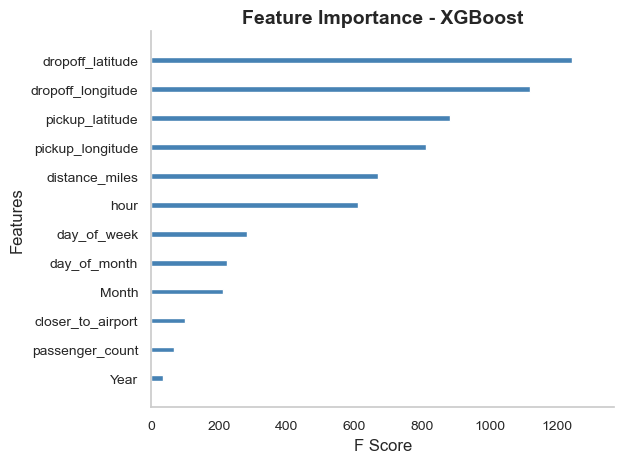

In [96]:
import matplotlib.pyplot as plt
from xgboost import plot_importance

# Plot feature importance
plt.figure(figsize=(10, 6))

# Generate feature importance plot without the grid and with a professional color
plot_importance(xgb, importance_type='weight', title='Feature Importance - XGBoost',
                grid=False, color='steelblue', show_values=False)

# Customize plot appearance
plt.title('Feature Importance - XGBoost', fontsize=14, fontweight='bold')
plt.xlabel('F Score', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Remove the grid
plt.grid(False)

# Remove the box around the plot
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Show the plot
plt.tight_layout()
plt.show()
